# Introduction 
Following through [this excellent tutorial](https://rpubs.com/adam_dennett/257231) by Adam Dennett on geospatial flow modelling. The focus of this notebook is:
- Getting and cleaning data on commuter flows from StatsNZ
- Plotting the flow data onto the territorial authorities map for Wellington
- Findng the data equivalents used in the RPubs analysis for Wellington 
- Presenting and understanding the basic unconstrained model of spatial flows

# Package installation
I'm working from a Ubuntu 18.04 VM on Windows. I needed to install a bunch of additional linux packages for the necessary R libraries and their dependencies:
- sudo apt  install protobuf-compiler
- sudo apt install libprotobuf-dev
- sudo apt install libv8-3.14-dev
- sudo apt-get install libjq-dev
- sudo apt install libudunits2-dev
- sudo apt install libgdal-dev
- sudo apt install libgdal1-dev (though I'm not 100% sure of this one)


In [25]:
library(sp)
library(MASS)
library(reshape2)
library(geojsonio)
library(rgdal)
library(downloader)
library(maptools)
library(tmap)
library(dplyr)
library(broom) 
library(stplanr)
library(ggplot2)
library(leaflet)
library(sf)

# Notebook configurations
options(warn=-1) # Turn on Warnings with warn=0

Linking to GEOS 3.6.2, GDAL 2.2.3, proj.4 4.9.3


# Data
There 4 key data sources for spatial flow modelling: 
- Geography shape file of the region
- Flow data
- Destination "attractiveness" features
- Origin "migration propensity" features

All 4 data sources have to be aggregated at the same spatial unit level. For this example, I've chosen to go with "statistical area 2" spatial unit. This is a mid-level coarse graining of the Wellington TA that loosely corresponds to suburbs. 

Data | Source 
--- | --- 
Geography shape file of the region | Stats NZ
Flow data | Stats NZ Commuter Flows visualisation
Destination "attractiveness" features | Mean personal income calculated from # people in income brackets
Origin "migration propensity" features | Population

Some notes: 
- Mean income is calculated from the coarse income brackets using the mid-bracket value. Because of the bracketing, it's only possible to calculate the mean, not the preferred median. I don't feel that this is a robust calculation since (1) the larger income brackets are much wider, and (2) the very high income bracket is not bounded - it's $150,000 and above.  
- Population value to use? As a simple approximating, we can use the number of commuting adults as the "population" - though it's the working, commuting, adult population of the area. 

## Getting flow data
Commuter flows from the NZ census are not available in a handy tabular format. But StatsNZ have provided a [Beta version of a commuter flow interactive map](https://www.stats.govt.nz/tools/commuter-view). I manually downloaded the flow data for each of the wards within the Wellington City territorial authority. The data is limited because the Wellington City TA doesn't capture the Hutt Valley or Porirua - two key suburban areas of the Greater Wellington region. Once I have a basic version of the model running, I'll extract the complete dataset. 

In [5]:
df <- read.csv("data/commuter_flow_wellington_city.csv")
colnames(df) <- c('to_code', 'to_name', 'flow_type', 'year_2006', 'year_2013', 'from_code', 'from_name')
df$year_2006 <- as.numeric(as.character(df$year_2006));
df$year_2013 <- as.numeric(as.character(df$year_2013));

In [6]:
df_clean <- df %>% filter(to_name %in% from_name) %>% filter(flow_type == 'in')
df_clean %>% head()

to_code,to_name,flow_type,year_2006,year_2013,from_code,from_name
576500,Adelaide,in,0,0,576500,Adelaide
573200,Aro Street-Nairn Street,in,42,33,576500,Adelaide
574401,Awarua,in,24,36,576500,Adelaide
576302,Berhampore East,in,30,39,576500,Adelaide
576200,Berhampore West,in,60,84,576500,Adelaide
575600,Brooklyn,in,45,81,576500,Adelaide


In [7]:
df_matrix <- dcast(df_clean,
                   from_name ~ to_name,
                   sum,
                   value.var = "year_2013",
                   margins=c("from_name", "to_name"))


In [8]:
df_matrix %>% head()

from_name,Adelaide,Aro Street-Nairn Street,Awarua,Berhampore East,Berhampore West,Brooklyn,Brooklyn South,Churton Park North,Churton Park South,⋯,Tawa South,Te Kainga,Thorndon-Tinakori Road,Vogeltown,Vogeltown West,Wadestown,Willis Street-Cambridge Terrace,Wilton,Woodridge,(all)
Adelaide,0,33,36,39,84,81,21,27,51,⋯,30,45,33,36,12,45,84,27,24,3300
Aro Street-Nairn Street,0,0,0,0,0,12,0,0,0,⋯,0,6,0,0,0,0,0,0,0,69
Awarua,0,0,0,0,0,0,0,0,0,⋯,0,6,0,0,0,0,0,0,0,6
Berhampore West,0,0,0,9,0,0,0,0,0,⋯,0,0,0,0,0,0,6,0,0,129
Brooklyn,0,0,0,0,0,0,12,0,0,⋯,0,0,0,0,9,0,6,0,0,81
Churton Park North,0,0,0,0,0,0,0,0,24,⋯,0,0,0,0,0,0,0,0,0,48


## Spatial area features

In [130]:
income_df <- read.csv("data//wellington-city-ta-personal-income-bracket.csv", sep=';', strip.white=T)
income_df <- tibble::rownames_to_column(income_df)

In [131]:
income_df %>% head()

rowname,ward,Total.people..total.personal.income,Loss,Zero.income,X.1..5.000,X.5.001..10.000,X.10.001..15.000,X.15.001..20.000,X.20.001..25.000,⋯,X.30.001..35.000,X.35.001..40.000,X.40.001..50.000,X.50.001..60.000,X.60.001..70.000,X.70.001..100.000,X.100.001..150.000,X.150.001.or.more,Total.people.stated,Not.stated
Tawa South,NA,2838,6,192,192,132,183,195,180,⋯,120,111,237,216,153,333,216,90,2676,159
Tawa Central,NA,3444,9,282,207,150,213,261,222,⋯,165,174,321,267,219,372,156,42,3231,213
Linden,NA,3123,18,285,204,174,201,231,186,⋯,144,180,294,222,183,246,117,42,2883,240
Greenacres,NA,1239,0,102,75,60,63,66,63,⋯,45,48,111,105,75,177,84,39,1182,54
Thorndon-Tinakori Road,NA,3804,12,141,162,156,195,195,153,⋯,135,165,369,348,267,522,312,255,3543,261
Lambton,NA,5451,24,405,762,573,420,258,216,⋯,171,195,387,339,222,420,282,159,4989,462


In [132]:
factorToNum <- function(x){
    y <- as.numeric(as.character(x))
    return(y)
}


income_vals <- income_df[,5:19]
salary_levels <- colnames(income_vals)
income_vals <- as.data.frame(sapply( income_vals, factorToNum ));
income_vals$statistical_area <- income_df$rowname


people <-  income_df[, 20];
people <- as.data.frame(sapply(people, factorToNum));
colnames(people) <- c('total')
people$statistical_area <- as.factor(income_df$rowname)

In [133]:
income_numeric <- data.frame(income_mid = c(0, seq(2500, 40000, 5000), seq(45000, 70000, 10000), 90000, 125000, 200000))
income_numeric$salary_levels <- salary_levels
income_numeric %>% head()

income_mid,salary_levels
0,Zero.income
2500,X.1..5.000
7500,X.5.001..10.000
12500,X.10.001..15.000
17500,X.15.001..20.000
22500,X.20.001..25.000


In [134]:
income_by_statistical_area <- melt(income_vals) 
income_by_statistical_area <- inner_join(income_by_statistical_area, 
                                         income_numeric,
                                         by = c("variable" = "salary_levels"))

Using statistical_area as id variables


In [135]:
mean_income_df <- income_by_statistical_area %>% 
                    filter(statistical_area %in% df_clean$to_name) %>% 
                    group_by(statistical_area) %>% 
                    summarise(total_calc_income = sum(value * income_mid)) %>% 
                    inner_join(people) %>% 
                    mutate(mean_calc_income = total_calc_income / total) %>% 
                    arrange(desc(mean_calc_income)) 

mean_income_df$statistical_area <- as.factor(mean_income_df$statistical_area)
mean_income_df %>% head()

Joining, by = "statistical_area"


statistical_area,total_calc_income,total,mean_calc_income
Kaiwharawhara,10327500,117,88269.23
Wadestown,198255000,2661,74503.95
Oriental Bay,67785000,915,74081.97
Te Kainga,212250000,2877,73774.77
Seatoun,116887500,1602,72963.48
Karaka Bay-Worser Bay,79275000,1104,71807.07


# Spatial data
+proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150 +datum=nzgd49 +units=m +no_defs


## Get boundary data

In [136]:
wgtn <- readOGR("./data/wgtn-stat-area-2", layer="AU_TA_Wellington_CC")
wgtn

OGR data source with driver: ESRI Shapefile 
Source: "/home/shrividya/Documents/wellington-commutes/data/wgtn-stat-area-2", layer: "AU_TA_Wellington_CC"
with 68 features
It has 5 fields


class       : SpatialPolygonsDataFrame 
features    : 68 
extent      : 2645098, 2669062, 5981296, 6005477  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150 +datum=nzgd49 +units=m +no_defs +ellps=intl +towgs84=59.47,-5.04,187.44,0.47,-0.1,1.024,-4.5993 
variables   : 5
names       :  UID_AU_TA,  AU_NO, TA_NO,      AU_NAME,         TA_NAME 
min values  : 572500|047, 572500,   047,     Adelaide, Wellington City 
max values  : 577700|047, 577700,   047, Wilton-Otari, Wellington City 

## Calculate pairwise distances

In [155]:
# Calculate and tabulate pairwise distances
nz_grid = "+init=epsg:2193"
wgtn_grid <- spTransform(wgtn, nz_grid)
df_distance <- melt(spDists(wgtn_grid))

df_distance %>% head()

Var1,Var2,value
1,1,0.0000
2,1,1022.0148
3,1,1933.0866
4,1,8982.1969
5,1,687.4013
6,1,1009.7732


## Geo-munging

In [156]:
# Create the lookup dataframes to match with the pairwise distance dataframe
# Names dataframe: numeric sequence --> Name
names <- as.data.frame(as.character(wgtn$AU_NAME))
names$num <- seq(1, nrow(names))

# Code dataframe: Name --> GeoCode
code_df <- data.frame(wgtn$UID_AU_TA, wgtn$AU_NAME)
colnames(code_df) <- c('UID_AU_TA', 'geo_code')

In [157]:
# Clean up pairwise distance dataframe
# Join both To and From columns to names lookup DF
df_distance <- inner_join(df_distance, names, by=c("Var1"= "num"))
df_distance <- inner_join(df_distance, names, by=c("Var2"= "num"))

# Clean up To and From column names
colnames(df_distance) <- c('Var1', 'Var2', 'distance', 'from', 'to')

# Join to geo_code df
df_distance <- inner_join(df_distance, code_df, by=c("from"= "geo_code"))
df_distance <- inner_join(df_distance, code_df, by=c("to"= "geo_code"))

# Final cleanup: Order DF such that geo_code columns are at the start
# The geo_code ordering is important for the od2line function
df_distance <- df_distance %>% dplyr::select(-c(Var1, Var2))
colnames(df_distance) <- c( 'distance', 'from', 'to', 'Orig_Code', 'Dest_Code')
df_distance <- df_distance %>% 
                dplyr::select(Orig_Code, Dest_Code, distance, from, to) %>%
                filter(from != to)
# Look at pairwise distances
df_distance %>% head()

Orig_Code,Dest_Code,distance,from,to
573900|047,573800|047,1022.0148,Newlands North,Johnsonville East
573523|047,573800|047,1933.0866,Grenada Village,Johnsonville East
573400|047,573800|047,8982.1969,Mt Victoria West,Johnsonville East
573600|047,573800|047,687.4013,Johnsonville North,Johnsonville East
573700|047,573800|047,1009.7732,Johnsonville South,Johnsonville East
573000|047,573800|047,8043.5618,Lambton,Johnsonville East


In [158]:
df_commuter_popn <- df %>% 
                    filter(to_name %in% from_name) %>%
                    filter(flow_type == "out") %>%
                    group_by(from_name) %>%
                    summarise(commuting_popn = sum(year_2013))

df_commuter_popn %>% head()

from_name,commuting_popn
Adelaide,327
Aro Street-Nairn Street,1467
Awarua,3135
Berhampore East,333
Berhampore West,819
Brooklyn,1686


In [159]:
df_distance <- inner_join(df_distance, mean_income_df %>% select(-total), by=c("to" = "statistical_area"))
df_distance <- inner_join(df_distance, df_commuter_popn, by=c("from" = "from_name"))

df_distance %>% head()

Orig_Code,Dest_Code,distance,from,to,total_calc_income,mean_calc_income,commuting_popn
573900|047,573800|047,1022.0148,Newlands North,Johnsonville East,37747500,51357.14,897
573523|047,573800|047,1933.0866,Grenada Village,Johnsonville East,37747500,51357.14,426
573400|047,573800|047,8982.1969,Mt Victoria West,Johnsonville East,37747500,51357.14,2775
573600|047,573800|047,687.4013,Johnsonville North,Johnsonville East,37747500,51357.14,600
573000|047,573800|047,8043.5618,Lambton,Johnsonville East,37747500,51357.14,1065
573200|047,573800|047,9491.6768,Aro Street-Nairn Street,Johnsonville East,37747500,51357.14,1467


## Plotting some flows

In [160]:
#use the od2line function from RObin Lovelace's excellent stplanr package
travel_network <- od2line(flow = df_distance %>% select(Orig_Code, Dest_Code, commuting_popn) %>% sample_n(20),  zones = wgtn)
travel_networkwgs <- spTransform(travel_network, nz_grid)
#And the Australia Map
nz_wgs <- spTransform(wgtn, nz_grid)
#and set the line widths to some sensible value according to the flow
w <- df_distance$commuting_popn / max(df_distance$commuting_popn) * 10
#now plot it...


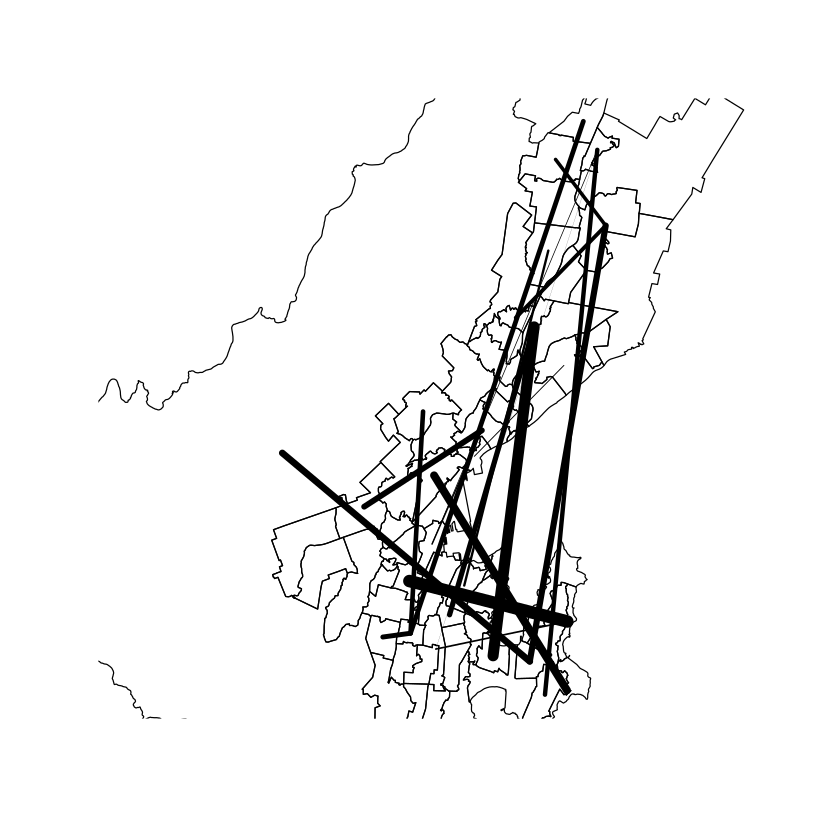

In [161]:
plot(travel_networkwgs, lwd = w)
plot(wgtn_grid, add=T)